
# Practical 1: word2vec

Oxford CS - Deep NLP 2017
https://www.cs.ox.ac.uk/teaching/courses/2016-2017/dl/

[Yannis Assael, Brendan Shillingford, Chris Dyer]

This practical is presented as an IPython Notebook, with the code written for recent versions of Python 3. The code in this practical will not work with Python 2 unless you modify it. If you are using your own Python installation, ensure you have a setup identical to that described in the installation shell script (which is intended for use with the department lab machines). We will be unable to support installation on personal machines due to time constraints, so please use the lab machines and the setup script if you are unfamiliar with how to install Anaconda.

To execute a notebook cell, press shift-enter. The return value of the last command will be displayed, if it is not None.

Potentially useful library documentation, references, and resources:

* IPython notebooks: https://ipython.org/ipython-doc/3/notebook/notebook.html#introduction
* Numpy numerical array library: https://docs.scipy.org/doc/
* Gensim's word2vec: https://radimrehurek.com/gensim/models/word2vec.html
* Bokeh interactive plots: http://bokeh.pydata.org/en/latest/ (we provide plotting code here, but click the thumbnails    for more examples to copy-paste)
* scikit-learn ML library (aka sklearn): http://scikit-learn.org/stable/documentation.html
* nltk NLP toolkit: http://www.nltk.org/
* tutorial for processing xml in python using lxml: http://lxml.de/tutorial.html (we did this for you below, but in case you need it in the future)



In [1]:
import numpy as np
import os
from random import shuffle
import re

In [2]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [3]:
import urllib.request
import zipfile
import lxml.etree

In [4]:


# Download the dataset if it's not already there: this may take a minute as it is 75MB
if not os.path.isfile('ted_en-20160408.zip'):
    urllib.request.urlretrieve("https://wit3.fbk.eu/get.php?path=XML_releases/xml/ted_en-20160408.zip&filename=ted_en-20160408.zip", filename="ted_en-20160408.zip")



In [5]:
# For now, we're only interested in the subtitle text, so let's extract that from the XML:
with zipfile.ZipFile('ted_en-20160408.zip', 'r') as z:
    doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r'))
input_text = '\n'.join(doc.xpath('//content/text()'))
del doc


# Part 1: Preprocessing

In this part, we attempt to clean up the raw subtitles a bit, so that we get only sentences. The following substring shows examples of what we're trying to get rid of. Since it's hard to define precisely what we want to get rid of, we'll just use some simple heuristics.


In [6]:
i = input_text.find("Hyowon Gweon: See this?")
input_text[i-20:i+150]

' baby does.\n(Video) Hyowon Gweon: See this? (Ball squeaks) Did you see that? (Ball squeaks) Cool. See this one? (Ball squeaks) Wow.\nLaura Schulz: Told you. (Laughs)\n(Vide'

Let's start by removing all parenthesized strings using a regex:

In [7]:
input_text_noparens = re.sub(r'\([^)]*\)', '', input_text)

We can verify the same location in the text is now clean as follows. We won't worry about the irregular spaces since we'll later split the text into sentences and tokenize it anyway.

In [8]:
i = input_text_noparens.find("Hyowon Gweon: See this?")
input_text_noparens[i-20:i+150]

"hat the baby does.\n Hyowon Gweon: See this?  Did you see that?  Cool. See this one?  Wow.\nLaura Schulz: Told you. \n HG: See this one?  Hey Clara, this one's for you. You "

Now, let's attempt to remove speakers' names that occur at the beginning of a line, by deleting pieces of the form " < up to 20 characters>: ", as shown in this example. Of course, this is an imperfect heuristic.

In [9]:
sentences_strings_ted = []
for line in input_text_noparens.split('\n'):
    m = re.match(r'^(?:(?P<precolon>[^:]{,20}):)?(?P<postcolon>.*)$', line)
    sentences_strings_ted.extend(sent for sent in m.groupdict()['postcolon'].split('.') if sent)

# Uncomment if you need to save some RAM: these strings are about 50MB.
# del input_text, input_text_noparens

# Let's view the first few:
sentences_strings_ted[:5]

["Here are two reasons companies fail: they only do more of the same, or they only do what's new",
 'To me the real, real solution to quality growth is figuring out the balance between two activities: exploration and exploitation',
 ' Both are necessary, but it can be too much of a good thing',
 'Consider Facit',
 " I'm actually old enough to remember them"]

Now that we have sentences, we're ready to tokenize each of them into words. This tokenization is imperfect, of course. For instance, how many tokens is "can't", and where/how do we split it? We'll take the simplest naive approach of splitting on spaces. Before splitting, we remove non-alphanumeric characters, such as punctuation. You may want to consider the following question: why do we replace these characters with spaces rather than deleting them? Think of a case where this yields a different answer.

In [10]:
sentences_ted = []
for sent_str in sentences_strings_ted:
    tokens = re.sub(r"[^a-z0-9]+", " ", sent_str.lower()).split()
    sentences_ted.append(tokens)

Two sample processed sentences:

In [11]:
len(sentences_ted)

266694

In [12]:
print(sentences_ted[0])
print(sentences_ted[1])

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']



## Part 2: Word Frequencies

If you store the counts of the top 1000 words in a list called counts_ted_top1000, the code below will plot the histogram requested in the writeup.


In [23]:
words_to_count = []
from collections import Counter
for i in range(1, len(sentences_ted)):
    for word in sentences_ted[i]:
        words_to_count.append(word)

c = Counter(words_to_count)


In [25]:
counts_ted_top1000 = c.most_common(1000)
counts_ted_top1000


[('the', 207747),
 ('and', 149305),
 ('to', 125169),
 ('of', 114817),
 ('a', 105399),
 ('that', 95146),
 ('i', 83180),
 ('in', 78070),
 ('it', 74738),
 ('you', 70923),
 ('we', 67629),
 ('is', 63251),
 ('s', 57155),
 ('this', 49241),
 ('so', 37014),
 ('they', 33100),
 ('was', 30806),
 ('for', 29713),
 ('are', 27994),
 ('have', 27344),
 ('but', 26732),
 ('what', 26518),
 ('on', 25962),
 ('with', 24706),
 ('can', 23377),
 ('t', 22757),
 ('about', 21246),
 ('there', 21041),
 ('be', 20201),
 ('as', 19488),
 ('at', 19216),
 ('all', 19021),
 ('not', 18626),
 ('do', 17926),
 ('my', 17908),
 ('one', 17551),
 ('re', 17012),
 ('people', 16723),
 ('like', 16273),
 ('if', 15868),
 ('from', 15452),
 ('now', 14387),
 ('our', 14061),
 ('he', 13986),
 ('an', 13917),
 ('just', 13896),
 ('these', 13882),
 ('or', 13863),
 ('when', 13278),
 ('because', 12879),
 ('very', 12363),
 ('me', 12302),
 ('out', 12163),
 ('by', 11935),
 ('them', 11595),
 ('how', 11576),
 ('know', 11506),
 ('up', 11445),
 ('going', 1

In [35]:
 counts_ted_top1000[1][1] 

149305

Plot distribution of top-1000 words

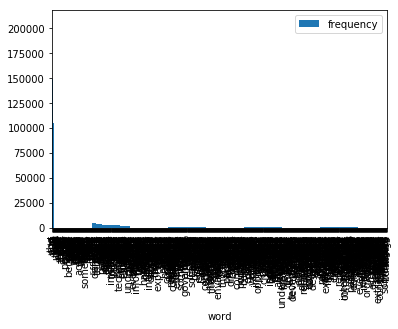

In [36]:
# Using pandas
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(counts_ted_top1000, columns=['word', 'frequency'])
df.plot(kind='bar', x='word')

In [37]:
words = []
frequency = []
words, frequency = zip(*counts_ted_top1000)

hist, edges = np.histogram(frequency, density=True, bins=100, normed=True)

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="Top-1000 words distribution")
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="#555555")
show(p)


## Part 3: Train Word2Vec

In [40]:
from gensim.models import Word2Vec

In [41]:
model_ted = Word2Vec(sentences_ted)

## Part 4: Ted Learnt Representations

Finding similar words: (see gensim docs for more functionality of most_similar)

In [42]:
model_ted.most_similar("man")

/home/raf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('woman', 0.8497142195701599),
 ('guy', 0.8191272616386414),
 ('lady', 0.7545516490936279),
 ('boy', 0.7516980767250061),
 ('girl', 0.7391645908355713),
 ('gentleman', 0.739057719707489),
 ('soldier', 0.7304814457893372),
 ('kid', 0.6968026161193848),
 ('poet', 0.6862804293632507),
 ('david', 0.6709516048431396)]

In [43]:
model_ted.most_similar("computer")

/home/raf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('software', 0.7411623597145081),
 ('machine', 0.7374176383018494),
 ('device', 0.703219473361969),
 ('robot', 0.7015794515609741),
 ('simulation', 0.6867383718490601),
 ('3d', 0.6849018931388855),
 ('printer', 0.6728560328483582),
 ('mechanical', 0.6456978917121887),
 ('program', 0.6352702379226685),
 ('interface', 0.6338328123092651)]

In [44]:
model_ted.most_similar("day")

/home/raf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('week', 0.7209201455116272),
 ('night', 0.6998276710510254),
 ('morning', 0.6957970857620239),
 ('evening', 0.6760390400886536),
 ('season', 0.5911001563072205),
 ('month', 0.5884741544723511),
 ('minute', 0.5861162543296814),
 ('afternoon', 0.579608678817749),
 ('year', 0.5747408270835876),
 ('time', 0.5618806481361389)]

### t-SNE visualization

To use the t-SNE code below, first put a list of the top 1000 words (as strings) into a variable words_top_ted. The following code gets the corresponding vectors from the model, assuming it's called model_ted:

In [45]:
# This assumes words_top_ted is a list of strings, the top 1000 words

words_top_vec_ted = model_ted[words]

/home/raf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
words_top_ted_tsne = tsne.fit_transform(words_top_vec_ted)

In [48]:
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=words_top_ted_tsne[:,0],
                                    x2=words_top_ted_tsne[:,1],
                                    names=words))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

## Part 5: Wiki Learnt Representations

Download dataset


In [49]:
if not os.path.isfile('wikitext-103-raw-v1.zip'):
    urllib.request.urlretrieve("https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-raw-v1.zip", filename="wikitext-103-raw-v1.zip")

In [56]:
with zipfile.ZipFile('wikitext-103-raw-v1.zip', 'r') as z:
    input_text = str(z.open('wikitext-103-raw/wiki.train.raw', 'r').read(), encoding='utf-8') # Thanks Robert Bastian

Preprocess sentences (note that it's important to remove small sentences for performance)

In [57]:
sentences_wiki = []
for line in input_text.split('\n'):
    s = [x for x in line.split('.') if x and len(x.split()) >= 5]
    sentences_wiki.extend(s)
    
for s_i in range(len(sentences_wiki)):
    sentences_wiki[s_i] = re.sub("[^a-z]", " ", sentences_wiki[s_i].lower())
    sentences_wiki[s_i] = re.sub(r'\([^)]*\)', '', sentences_wiki[s_i])
del input_text

In [58]:
# sample 1/5 of the data
shuffle(sentences_wiki)
print(len(sentences_wiki))
sentences_wiki = sentences_wiki[:int(len(sentences_wiki)/5)]
print(len(sentences_wiki))

4267112
853422


In [59]:
sentences_wiki[0]

' the abolitionist movement attracted those who did not want to be part of a party led by slavery     supporting southerners '

In [61]:
sentences_new_wiki = []
for sent_str in sentences_wiki:
    tokens = re.sub(r"[^a-z0-9]+", " ", sent_str.lower()).split()
    sentences_new_wiki.append(tokens)

In [64]:
len(sentences_new_wiki)

853422

Now, repeat all the same steps that you performed above. You should be able to reuse essentially all the code.

In [65]:
words_to_count = []
for i in range(1, len(sentences_new_wiki)):
    for word in sentences_new_wiki[i]:
        words_to_count.append(word)

c = Counter(words_to_count)
counts_wiki_top1000 = c.most_common(1000)
counts_wiki_top1000

[('the', 1285506),
 ('of', 547398),
 ('and', 500469),
 ('in', 433974),
 ('to', 397512),
 ('a', 358663),
 ('was', 214140),
 ('s', 164184),
 ('on', 154438),
 ('as', 144602),
 ('for', 139116),
 ('that', 138828),
 ('with', 129861),
 ('by', 125846),
 ('is', 103385),
 ('his', 92699),
 ('at', 92149),
 ('he', 91406),
 ('from', 89252),
 ('it', 88921),
 ('were', 70636),
 ('an', 64065),
 ('had', 58929),
 ('which', 55220),
 ('be', 47097),
 ('this', 43399),
 ('but', 42325),
 ('are', 41127),
 ('first', 40700),
 ('not', 40003),
 ('their', 38870),
 ('after', 38357),
 ('one', 38297),
 ('also', 37313),
 ('her', 37231),
 ('its', 36846),
 ('they', 35093),
 ('two', 34205),
 ('or', 33538),
 ('have', 32976),
 ('who', 31766),
 ('new', 30695),
 ('been', 30469),
 ('has', 30018),
 ('she', 29342),
 ('when', 27168),
 ('time', 26329),
 ('during', 26309),
 ('other', 25693),
 ('would', 25234),
 ('into', 24854),
 ('all', 24174),
 ('i', 23786),
 ('more', 22769),
 ('while', 21431),
 ('over', 21126),
 ('game', 19857),
 (

### t-SNE visualization

In [67]:
# This assumes words_top_wiki is a list of strings, the top 1000 words
words_top_wiki, frequency = zip(*counts_wiki_top1000)

model_wiki = Word2Vec(sentences_new_wiki)

words_top_vec_wiki = model_wiki[words_top_wiki]



tsne = TSNE(n_components=2, random_state=0)
words_top_wiki_tsne = tsne.fit_transform(words_top_vec_wiki)

/home/raf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [68]:


p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=words_top_wiki_tsne[:,0],
                                    x2=words_top_wiki_tsne[:,1],
                                    names=words_top_wiki))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

